In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import numpy as np
import os
import sys
import time
import cv2
import PIL.Image
import random
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import roc_auc_score
%matplotlib inline
import seaborn as sns
from pylab import rcParams
import timm
from warnings import filterwarnings
from sklearn.preprocessing import LabelEncoder
import math
import glob
from sklearn.model_selection import StratifiedKFold, GroupKFold
filterwarnings("ignore")

device = "cuda" if torch.cuda.is_available() else "cpu"

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    print(f'Setting all seeds to be {seed} to reproduce...')
    
seed_everything(1126)

Setting all seeds to be 1126 to reproduce...


In [4]:
image_size = 512
batch_size = 16
n_worker = 2
init_lr = 3e-4
n_epochs = 6 # from my experiments, use > 25 when margin = 0.5
fold_id = 0
holdout_id = 0
valid_every = 5
save_after = 10
margin = 0.5 # 0 for faster convergence, larger may be beneficial
search_space = np.arange(40, 100, 10) # in my experiments, thresholds should be between 40 - 90 (/100) for cosine similarity
use_amp = False # todo: figure how to work with pytorch native amp
debug = True # set this to False to train in full
kernel_type = 'baseline'
model_dir = './weights/'
data_dir = '/kaggle/input/shopee-product-matching/train_images'

In [5]:
df_train = pd.read_csv('/kaggle/input/shopee-product-matching/train.csv')
df_train.loc[:, 'file_path'] = df_train.image.apply(lambda x: os.path.join(data_dir, x))

In [6]:
df_train.head()

,posting_id,image,image_phash,title,label_group,file_path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/kaggle/input/shopee-product-matching/train_im...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/kaggle/input/shopee-product-matching/train_im...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/kaggle/input/shopee-product-matching/train_im...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/kaggle/input/shopee-product-matching/train_im...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/kaggle/input/shopee-product-matching/train_im...


In [7]:
gkf = GroupKFold(n_splits = 5)
df_train.loc[:, 'fold'] = -1

for fold, (train_idx, valid_idx) in enumerate(gkf.split(df_train, None, df_train.label_group)):
    df_train.loc[valid_idx, 'fold'] = fold

In [8]:
df_train.head()

,posting_id,image,image_phash,title,label_group,file_path,fold
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,/kaggle/input/shopee-product-matching/train_im...,3
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,/kaggle/input/shopee-product-matching/train_im...,3
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,/kaggle/input/shopee-product-matching/train_im...,4
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,/kaggle/input/shopee-product-matching/train_im...,3
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,/kaggle/input/shopee-product-matching/train_im...,1


In [9]:
le = LabelEncoder()
df_train.label_group = le.fit_transform(df_train.label_group)

In [10]:
df_train.head()

,posting_id,image,image_phash,title,label_group,file_path,fold
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,666,/kaggle/input/shopee-product-matching/train_im...,3
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",7572,/kaggle/input/shopee-product-matching/train_im...,3
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,6172,/kaggle/input/shopee-product-matching/train_im...,4
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,10509,/kaggle/input/shopee-product-matching/train_im...,3
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,9425,/kaggle/input/shopee-product-matching/train_im...,1


In [11]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p = 0.5),
    albumentations.RandomBrightnessContrast(p = 0.5, brightness_limit = (-0.2, 0.2),
                                           contrast_limit = (-0.2, 0.2)),
    albumentations.HueSaturationValue(p = 0.5, hue_shift_limit = 0.2, sat_shift_limit = 0.2,
                                      val_shift_limit = 0.2),
    albumentations.ShiftScaleRotate(p = 0.5, shift_limit = 0.0625, scale_limit = 0.2, 
                                    rotate_limit = 20),
    albumentations.CoarseDropout(p = 0.5),
    albumentations.Normalize()
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.Normalize()
])

In [12]:
class SHOPEEDataset(Dataset):
    def __init__(self, df, mode, transform):
        self.df = df.reset_index(drop = True)
        self.mode = mode
        self.transform = transform
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        img = cv2.imread(row.file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        
        if self.transform is not None:
            result = self.transform(image = img)
            img = result['image']
            
        img = img.astype(np.float32)
        img = img.transpose(2, 0, 1)
        
        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(row.label_group).float()
    
    def __len__(self):
        
        return len(self.df)

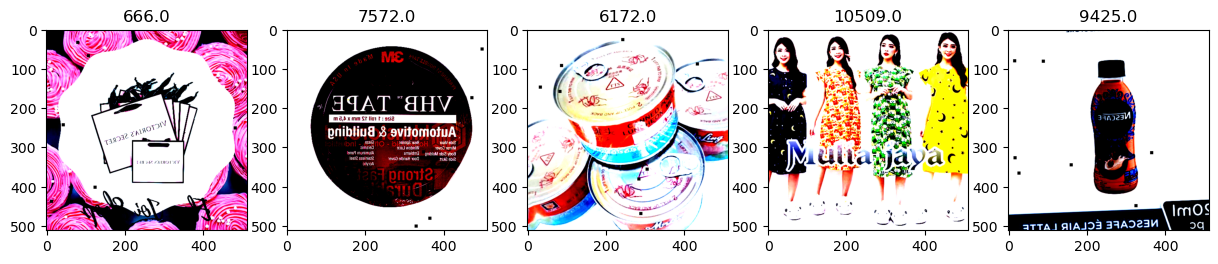

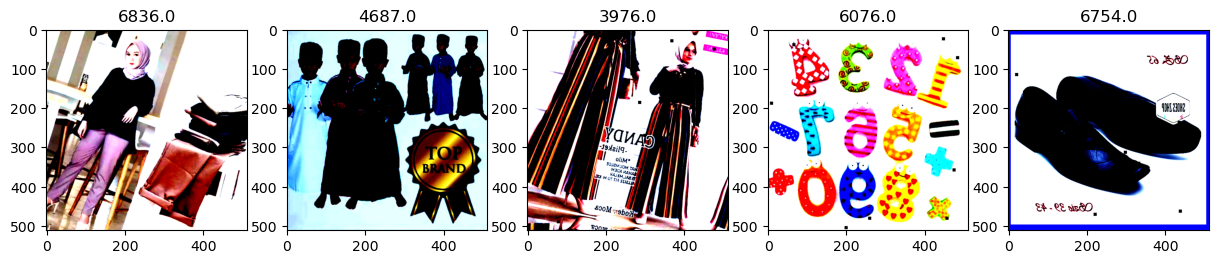

In [13]:
dataset = SHOPEEDataset(df_train, 'train', transform = transforms_train)
rcParams['figure.figsize'] = 15,5
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = i*5 + p
        img, label = dataset[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())

In [14]:
class ArcModule(nn.Module):
    def __init__(self, in_features, out_features, s = 10, m = margin):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = torch.tensor(math.cos(math.pi - m))
        self.mm = torch.tensor(math.sin(math.pi - m) * m)
    
    def forward(self, inputs, labels):
        cos_th = F.linear(inputs, F.normalize(self.weight))
        cos_th = cos_th.clamp(-1, 1)
        sin_th = torch.sqrt(1.0 - torch.pow(cos_th, 2))
        cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m
        # print(type(cos_th), type(self.th), type(cos_th_m), type(self.mm))
        cos_th_m = torch.where(cos_th > self.th, cos_th_m, cos_th - self.mm)

        cond_v = cos_th - self.th
        cond = cond_v <= 0
        cos_th_m[cond] = (cos_th - self.mm)[cond]

        if labels.dim() == 1:
            labels = labels.unsqueeze(-1)
        onehot = torch.zeros(cos_th.size()).cuda()
        labels = labels.type(torch.LongTensor).cuda()
        onehot.scatter_(1, labels, 1.0)
        outputs = onehot * cos_th_m + (1.0 - onehot) * cos_th
        outputs = outputs * self.s
        return outputs

In [15]:
class SHOPEEDenseNet(nn.Module):
    def __init__(self, channel_size, out_feature, dropout = 0.5, backbone = 'densenet121', 
                pretrained = True):
        super(SHOPEEDenseNet, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained = pretrained)
        self.channel_size = channel_size
        self.out_feature = out_feature
        self.in_features = self.backbone.classifier.in_features
        self.margin = ArcModule(in_features = self.channel_size, out_features = self.out_feature)
        self.bn1 = nn.BatchNorm2d(self.in_features)
        self.dropout = nn.Dropout2d(dropout, inplace = True)
        self.fc1 = nn.Linear(self.in_features * 16 * 16 , self.channel_size)
        self.bn2 = nn.BatchNorm1d(self.channel_size)
        
    def forward(self, x, labels = None):
        features = self.backbone.features(x)
        features = self.bn1(features)
        features = self.dropout(features)
        features = features.view(features.size(0), -1)
        features = self.fc1(features)
        features = self.bn2(features)
        features = F.normalize(features)
        
        if labels is not None:
            return self.margin(features, labels)
        return features

In [16]:
model = SHOPEEDenseNet(512, df_train.label_group.nunique())
model.to(device)

SHOPEEDenseNet(
  (backbone): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNormAct2d(
        64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): ReLU(inplace=True)
      )
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): DenseBlock(
        (denselayer1): DenseLayer(
          (norm1): BatchNormAct2d(
            64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNormAct2d(
            128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (conv2): Conv2d(128, 32,

In [17]:
def train_func(train_loader):
    model.train()
    bar = tqdm(train_loader)
    losses = []
    
    for batch in bar:
        images, targets = batch
        images, targets = images.to(device), targets.to(device).long()
        
        logits = model(images, targets)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        smooth_loss = np.mean(losses[-30:])
        
        bar.set_description(f'loss: {loss.item():.5f}, smooth: {smooth_loss:.5f}')
    
    loss_train = np.mean(losses)
    
    return loss_train

In [18]:
def valid_func(valid_loader):
    model.eval()
    bar = tqdm(valid_loader)
    ARGETS = []
    losses = []
    PREDS = []
    
    with torch.no_grad():
        for batch in bar:
            images, targets = batch
            images, targets = images.to(device), targets.to(device).long()

            logits = model(images, targets)
            loss = criterion(logits, targets)
            PREDS += [torch.argmax(logits, 1).detach().cpu()]
            TARGETS += [targets.detach().cpu()]

            losses.append(loss.item())
            smooth_loss = np.mean(losses[-30:])

            bar.set_description(f'loss: {loss.item():.5f}')
    
    loss_valid = np.mean(losses)
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()    
    acc = (PREDS == TARGETS).mean()
    
    return loss_valid, acc

In [19]:
def generate_test_features(test_loader):
    model.eval()
    bar = tqdm(valid_loader)
    FEAS = []
    
    with torch.no_grad():
        for batch in bar:
            images = batch.to(device)
            features = model(images)

            FEAS += [features.detach().cpu()]
    
    FEAS = torch.cat(FEAS).cpu().numpy()
    
    return FEAS

In [20]:
def row_wise_f1_score(labels, preds):
    scores = []
    for label, pred in zip(labels, preds):
        n = len(np.intersect1d(label, pred))
        score = 2 * n / (len(label)+len(pred))
        scores.append(score)
    return scores, np.mean(scores)

In [21]:
def find_threshold(df, lower_count_thresh, upper_count_thresh, search_space):
    '''
    Compute the optimal threshold for the given count threshold.
    '''
    score_by_threshold = []
    best_score = 0
    best_threshold = -1
    for i in tqdm(search_space):
        sim_thresh = i/100
        selection = ((FEAS@FEAS.T) > sim_thresh).cpu().numpy()
        matches = []
        oof = []
        for row in selection:
            oof.append(df.iloc[row].posting_id.tolist())
            matches.append(' '.join(df.iloc[row].posting_id.tolist()))
        tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
        df['target'] = df.label_group.map(tmp)
        scores, score = row_wise_f1_score(df.target, oof)
        df['score'] = scores
        df['oof'] = oof
        
        selected_score = df.query(f'count > {lower_count_thresh} and count < {upper_count_thresh}').score.mean()
        score_by_threshold.append(selected_score)
        if selected_score > best_score:
            best_score = selected_score
            best_threshold = i
            
    plt.title(f'Threshold Finder for count in [{lower_count_thresh},{upper_count_thresh}].')
    plt.plot(score_by_threshold)
    plt.axis('off')
    plt.show()
    print(f'Best score is {best_score} and best threshold is {best_threshold/100}')


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = init_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

In [23]:
df_train_this = df_train.loc[df_train.fold != fold_id, :]
df_valid_this = df_train.loc[df_train.fold == fold_id, :]
df_valid_this.loc[:, 'count'] = df_valid_this.label_group.map(
                                    df_valid_this.label_group.value_counts().to_dict())

dataset_train = SHOPEEDataset(df_train_this, 'train', transforms_train)
dataset_valid = SHOPEEDataset(df_valid_this, 'test', transforms_valid)

train_loader = DataLoader(dataset_train, batch_size = batch_size, num_workers = n_worker, 
                          shuffle = True)
valid_loader = DataLoader(dataset_valid, batch_size = batch_size, num_workers = n_worker, 
                          shuffle = False)

In [ ]:
for epoch in range(n_epochs):
    scheduler.step()
    loss_train = train_func(train_loader)
    
    if epoch % valid_every == 0:
        print('Now generating features for the validation set to simulate the submission.')
        FEAS = generate_test_features(valid_loader)
        FEAS = torch.tensor(FEAS).cuda()
        print('Finding Best Threshold in the given search space.')
        find_threshold(df = df_valid_this, 
               lower_count_thresh = 0, 
               upper_count_thresh = 999,
               search_space = search_space)
        if epoch >= save_after:
            torch.save(model.state_dict(), 
                f'{model_dir}{kernel_type}_fold{fold_id}_densenet_{image_size}_epoch{epoch}.pth')